# What are good indicators of Yelp vote scores? 

This notebook uses a small subset of the data from Kaggle's [Yelp Business Rating Prediction](https://www.kaggle.com/c/yelp-recsys-2013) competition.

**Description of the data:**

- Each observation in this dataset is a review of a particular business by a particular user.
- The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.
- The "cool" column is the number of "cool" votes this review received from other Yelp users. All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.
- The "useful" and "funny" columns are similar to the "cool" column.

In [94]:
# Dependencies
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json

%matplotlib inline

In [95]:
#read in dataframe

file = "2_dataset/yelp.csv"
df = pd.read_csv(file, index_col = "date")

In [96]:
# drop useless columns
cols = ["business_id", "review_id", "user_id"]
df.drop(cols, axis = 1, inplace = True)
df.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [97]:
# treat stars as a categorical variable and look for differences between groups
df.groupby("stars").describe()

cool                                                 funny            \
        count      mean       std  min  25%  50%  75%   max   count      mean   
stars                                                                           
1       749.0  0.576769  1.474759  0.0  0.0  0.0  1.0  17.0   749.0  1.056075   
2       927.0  0.719525  1.491182  0.0  0.0  0.0  1.0  14.0   927.0  0.875944   
3      1461.0  0.788501  1.602576  0.0  0.0  0.0  1.0  18.0  1461.0  0.694730   
4      3526.0  0.954623  2.034367  0.0  0.0  0.0  1.0  38.0  3526.0  0.670448   
5      3337.0  0.944261  2.484583  0.0  0.0  0.0  1.0  77.0  3337.0  0.608631   

       ...              useful                                                
       ...   75%   max   count      mean       std  min  25%  50%  75%   max  
stars  ...                                                                    
1      ...   1.0  30.0   749.0  1.604806  2.302354  0.0  0.0  1.0  2.0  20.0  
2      ...   1.0  20.0   927.0  1.563107  1.969546  0.0  0.0  1.0  2.0  17.0  
3      ...   1.0  24.0  1461.0  1.306639  1.985327  0.0  0.0  1.0  2.0  19.0  
4      ...   1.0  57.0  3526.0  1.395916  2.236087  0.0  0.0  1.0  2.0  38.0  
5      ...   1.0  39.0  3337.0  1.381780  2.659065  0.0  0.0  1.0  2.0  76.0  

[5 rows x 24 columns]

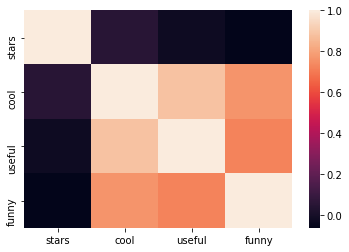

In [98]:
# correlation matrix
sns.heatmap(df.corr())

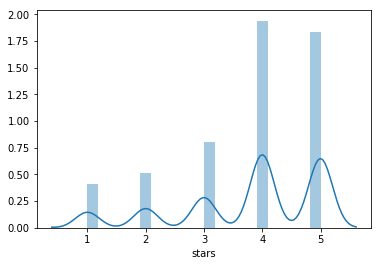

In [99]:
#check distribution of ratings
sns.distplot(df.stars)

In [100]:
#Fit a linear regression, examine coeffs

X = df[["cool", "useful", "funny"]]
y = df["stars"]

#import
from sklearn.linear_model import LinearRegression

#instantiate
linreg = LinearRegression()

#fit
linreg.fit(X, y)
print(list(zip(X, linreg.coef_)))

[('cool', 0.27435946858853061), ('useful', -0.14745239099401478), ('funny', -0.13567449053706179)]


In [101]:
#Train regression

#import
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5)

#instantiate
linreg = LinearRegression()

#train
linreg.fit(X_train, y_train)

#predict
y_pred = linreg.predict(X_test)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(rmse)

1.20904358047


In [102]:
# Create a function to make the rest of the project easier
def train_test_rmse(feature_list):
    X = df[feature_list]
    y = df.stars
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5)
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return rmse


In [103]:
# calculate RMSE with all three features
feature_list = ["cool", "useful", "funny"]
print(train_test_rmse(feature_list))

1.20904358047


In [104]:
# remove features to see if I can get lower... not much

feature_list = ["cool", "useful"]
print(train_test_rmse(feature_list))

1.19521148071


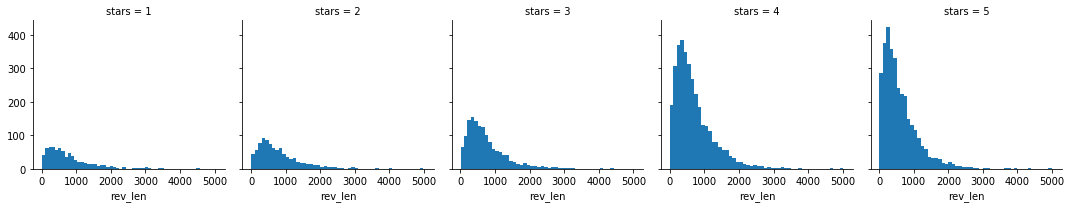

In [105]:
# feature engineering: review length (number of characters)
df["rev_len"] = df["text"].apply(len)

#facet grid
g = sns.FacetGrid(data=df, col="stars")
g.map(plt.hist, "rev_len", bins=50)

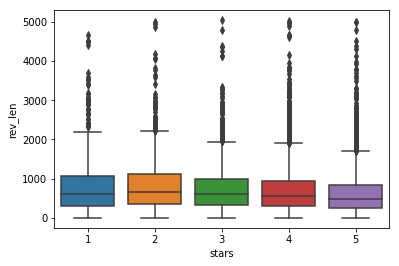

In [106]:
#length to stars
sns.boxplot(x="stars", y= "rev_len", data=df)


In [107]:
# feature engineering: whether or not the review contains 'love' or 'hate'
df["love"] = df["text"].str.contains("love")
df["hate"] = df["text"].str.contains("hate")

In [108]:
# add new features to the model and calculate RMSE ... a little better. 
feature_list = ["love", "rev_len", "cool"]
print(train_test_rmse(feature_list))

1.18311928984


## What's the role of language?
Can words predict the number of stars? 

In [109]:
#import NLP tools, as well as classification algorithms
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [110]:
#create binary dataframe
yelp_bw = df[(df.stars == 5) | (df.stars == 1)]
yelp_bw.is_copy = False #turning off the copy, since I don't work with chain
yelp_bw["stars"] = yelp_bw["stars"].map({5:1, 1:0})


In [111]:
#split the data into training and testing sets for cross-validation
X = yelp_bw.text
y = yelp_bw.stars

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1) #rs in case you want to replicate

In [112]:
#create document term matricies
#instantiate vectorizer
vect = CountVectorizer()

#vectorize-fit training model and vectorize test model
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#istantiate multinomial Bayes
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)

#predict
y_pred_prob = nb.predict(X_test_dtm)

In [113]:
#calculate the accuracy of the model  --- not bad! Better indication than votes (as expected)
print(metrics.accuracy_score(y_test, y_pred_prob))

0.918786692759


In [114]:
#confusion matrix to see where I'm off
metrics.confusion_matrix(y_test, y_pred_prob)

array([[126,  58],
       [ 25, 813]], dtype=int64)

In [115]:
#add in all of the reviews
X = df["text"]
y = df["stars"]

#train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

#create doc term matricies, fit_transform, fit
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

#instantiate
nb = MultinomialNB()

#fit
nb.fit(X_train_dtm, y_train)

#predict
y_pred_class = nb.predict(X_test_dtm)

#accuracy.......... Not good
print(metrics.accuracy_score(y_test, y_pred_class))

0.4844


In [116]:
#confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[ 60,  27,  19,  64,  26],
       [ 12,  16,  43, 132,  24],
       [  3,  10,  45, 270,  33],
       [  8,   1,  21, 646, 204],
       [  2,   3,   4, 383, 444]], dtype=int64)

## Some more language work...

In [117]:
#NLP and text mining Dependencies
import numpy as np
import scipy as sp
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag, pos_tag_sents

In [118]:
#Clean the text
stop = stopwords.words("english")
def stopwords(x):
    x = re.sub("[^a-z\s]", " ", x)
    x = [w for w in x.split() if w not in set(stop)]
    return " ".join(x)

df["text_clean"] = df["text"].apply(stopwords)

#create count of YELLING
def YELL(x):
    x = filter(None, [x.strip() for x in re.findall(r"\b[A-Z]+[A-Z]+[A-Z]\b", x)])
    return "".join(x)

df["yell_word"] = df["text"].apply(YELL)
df["yell_count"] = df["yell_word"].apply(len)


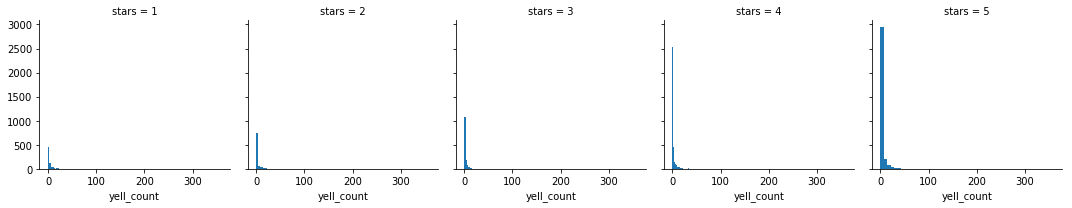

In [119]:
#yelling, visualized
y = sns.FacetGrid(data=df, col="stars")
y.map(plt.hist, "yell_count", bins=50)

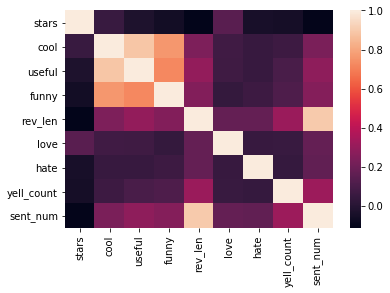

In [120]:
#tokenize sentences and words, label with pos
df["sent_token"] = df["text"].apply(sent_tokenize)
df["word_token"] = df["text"].apply(word_tokenize)
df["pos_tag"] = df["word_token"].apply(pos_tag)

#create a column with the number of sentences, check correlation
df["sent_num"] = df.sent_token.apply(len)
sns.heatmap(df.corr())

In [121]:
#create columns of nouns and noun counts
def NounFinder(x):
    nouns = []
    for (word, pos) in x:
        if pos.startswith("NN"):
            nouns.append((word, pos))
    return nouns

def PropNounFinder(x):
    proper = []
    for (word, pos) in x:
        if pos.startswith("NNP"):
            proper.append(word)
    return proper

df["nouns"] = df["pos_tag"].apply(NounCounter)
df["nnp"] = df["nouns"].apply(PropNounFinder)
df["noun_count"] = df["nouns"].str.len()
df["nnp_count"] = df["nnp"].str.len()

In [122]:
#create columns of adverbs and adverb counts
def AdverbFinder(x):
    adverbs = []
    for (word, pos) in x:
        if pos.startswith("RB"):
            adverbs.append((word, pos))
    return adverbs

def CompAdvFinder(x):
    comp = []
    for (word, pos) in x:
        if pos.startswith("RBR"):
            comp.append(word)
    return comp

def SupAdvFinder(x):
    sup = []
    for (word, pos) in x:
        if pos.startswith("RBS"):
            sup.append(word)
    return sup


df["adverbs"] = df["pos_tag"].apply(AdverbFinder)
df["adv_count"] = df["adverbs"].str.len()
df["comp_adv"] = df["adverbs"].apply(CompAdvFinder)
df["comp_adv_count"] = df["comp_adv"].str.len()
df["sup_adv"] = df["adverbs"].apply(SupAdvFinder)
df["sup_adv_count"] = df["sup_adv"].str.len()

In [123]:
#create columns of adjective and adjective counts
def AdjectiveFinder(x):
    adjectives = []
    for (word, pos) in x:
        if pos.startswith("JJ"):
            adjectives.append((word, pos))
    return adjectives

def CompAdjFinder(x):
    comp = []
    for (word, pos) in x:
        if pos.startswith("JJR"):
            comp.append(word)
    return comp

def SupAdjFinder(x):
    sup = []
    for (word, pos) in x:
        if pos.startswith("JJS"):
            sup.append(word)
    return sup

df["adjectives"] = df["pos_tag"].apply(AdjectiveFinder)
df["adj_count"] = df["adjectives"].str.len()
df["comp_adj"] = df["adjectives"].apply(CompAdjFinder)
df["comp_adj_count"] = df["comp_adj"].str.len()
df["sup_adj"] = df["adjectives"].apply(SupAdjFinder)
df["sup_adj_count"] = df["sup_adj"].str.len()

In [124]:
#create columns of adverbs and adverb counts
def VerbFinder(x):
    verbs = []
    for (word, pos) in x:
        if pos.startswith("VB"):
            verbs.append((word, pos))
    return verbs

def PresentVerb(x):
    present = []
    for (word, pos) in x:
        if pos.startswith("VBG" or "VBP" or "VBZ"):
            present.append(word)
    return present

def PastVerb(x):
    past = []
    for (word, pos) in x:
        if pos.startswith("VBD" or "VBN"):
            past.append(word)
    return past


df["verbs"] = df["pos_tag"].apply(VerbFinder)
df["verb_count"] = df["verbs"].str.len()
df["pres_verb"] = df["verbs"].apply(PresentVerb)
df["pres_verb_count"] = df["pres_verb"].str.len()
df["past_verb"] = df["verbs"].apply(PastVerb)
df["past_verb_count"] = df["past_verb"].str.len()

In [125]:
#find $ signs
def DollarFinder(x):
    money = []
    for (word, pos) in x:
        if pos.startswith("$"):
            money.append(word)
    return len(money)

df["dolla_signs"] = df["pos_tag"].apply(DollarFinder)

In [127]:
#relationships?
df.corr()

,stars,cool,useful,funny,rev_len,love,hate,yell_count,sent_num,noun_count,...,adv_count,comp_adv_count,sup_adv_count,adj_count,comp_adj_count,sup_adj_count,verb_count,pres_verb_count,past_verb_count,dolla_signs
stars,1.000000,0.052555,-0.023479,-0.061306,-0.114530,0.145064,-0.044853,-0.052292,-0.109030,-0.080215,...,-0.148307,-0.067740,0.011645,-0.044881,-0.104964,0.025559,-0.155976,-0.132360,-0.196599,-0.073539
cool,0.052555,1.000000,0.887102,0.764342,0.242238,0.073532,0.047057,0.065164,0.232936,0.256527,...,0.191991,0.064869,0.044234,0.221115,0.083605,0.076752,0.221004,0.204460,0.152658,0.088353
useful,-0.023479,0.887102,1.000000,0.723406,0.294760,0.071558,0.046742,0.101293,0.281772,0.303734,...,0.244471,0.083269,0.050538,0.266212,0.117963,0.098219,0.275573,0.245564,0.199705,0.117492
funny,-0.061306,0.764342,0.723406,1.000000,0.252722,0.041069,0.064012,0.112077,0.257888,0.264784,...,0.209414,0.065656,0.044495,0.209118,0.086701,0.073172,0.240791,0.235557,0.160365,0.085497
rev_len,-0.114530,0.242238,0.294760,0.252722,1.000000,0.174197,0.175360,0.315509,0.902012,0.972656,...,0.901364,0.335072,0.198561,0.923352,0.442452,0.385969,0.970599,0.770043,0.772884,0.290366
love,0.145064,0.073532,0.071558,0.041069,0.174197,1.000000,0.049187,0.055171,0.175467,0.172427,...,0.155025,0.045387,0.031770,0.174446,0.063270,0.059216,0.170397,0.102143,0.094257,0.021281
hate,-0.044853,0.047057,0.046742,0.064012,0.175360,0.049187,1.000000,0.044701,0.168443,0.157068,...,0.187732,0.071496,0.045799,0.148826,0.092312,0.069274,0.187889,0.141979,0.116244,0.060839
yell_count,-0.052292,0.065164,0.101293,0.112077,0.315509,0.055171,0.044701,1.000000,0.319631,0.351273,...,0.268363,0.065726,0.053500,0.248256,0.129128,0.102347,0.299410,0.225563,0.214897,0.130332
sent_num,-0.109030,0.232936,0.281772,0.257888,0.902012,0.175467,0.168443,0.319631,1.000000,0.878403,...,0.822950,0.284977,0.161359,0.833500,0.383319,0.341742,0.887007,0.667640,0.728822,0.269654
noun_count,-0.080215,0.256527,0.303734,0.264784,0.972656,0.172427,0.157068,0.351273,0.878403,1.000000,...,0.827293,0.313535,0.189010,0.900337,0.419447,0.373057,0.909765,0.725531,0.712730,0.300147


At this point, it appears that language is not a good predictor of star rating. Future NLP work should look at sentiment analysis (polarity/subjectivity) as it relates to N/V/Adv/Adj usage for good (5, 4), neutral (3), and bad (2,1) reviews. 